<a href="https://colab.research.google.com/github/kosirobwada/KaggleDeepLearningBook/blob/main/2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader , TensorDataset

In [5]:
digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.3, stratify=y, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=0
)

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_valid, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [7]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataset = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
import numpy as np
import torch
from tqdm import tqdm

def validate_1epoch(model, val_loader, lossfun, device):
  model.eval()
  total_loss , total_acc = 0.0, 0.0

  with torch.no_grad():
    for x, y in tqdm(val_loader):
      x = x.to(device)
      y = y.to(device)

      out = model(x)
      loss = lossfun(out ,y)
      _, pred = torch.max(out, 1)

      total_loss += loss.item() * x.size(0)
      total_acc += torch.sum(pred==y.data)

    avg_loss = total_loss / len(val_loader.dataset)
    avg_acc = total_acc / len(val_loader.dataset)
    return avg_acc, avg_loss

In [9]:
def predict(model ,loader, device):
  pred_fun = torch.nn.Softmax(dim=1)
  preds = []

  for x, _ in tqdm(loader):
    with torch.set_grad_enabled(False):
      x = x.to(device)
      y = pred_fun(model(x))

    y = y.cpu().numpy()
    preds.append(y)
  preds = np.concatenate(preds)
  return preds

100%|██████████| 9/9 [00:00<00:00, 784.10it/s]


train acc 0.9990049600601196
valid acc 0.9642857313156128
test acc 0.9592592592592593


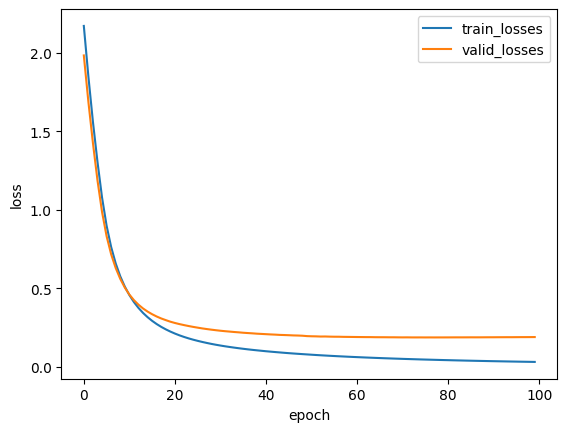

In [16]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


def seed_torch(seed=1485):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def train_1epoch(model, train_loader, lossfun, optimizer, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        # yの予測値を算出
        out = model(x)

        # 損失を計算
        loss = lossfun(out, y)
        loss.backward()

        # 勾配を更新
        optimizer.step()

        # バッチ単位の損失を計算
        total_loss += loss.item() * x.size(0)

        # バッチ単位の正答率を計算
        _, pred = torch.max(out, 1)
        total_acc += torch.sum(pred == y.data)

    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_acc / len(train_loader.dataset)
    return avg_acc, avg_loss


def validate_1epoch(model, val_loader, lossfun, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = lossfun(out, y)
            _, pred = torch.max(out, 1)

            total_loss += loss.item() * x.size(0)
            total_acc += torch.sum(pred == y.data)

    avg_loss = total_loss / len(val_loader.dataset)
    avg_acc = total_acc / len(val_loader.dataset)
    return avg_acc, avg_loss


def predict(model, loader, device):
    pred_fun = torch.nn.Softmax(dim=1)
    preds = []
    for x, _ in tqdm(loader):
        with torch.set_grad_enabled(False):
            x = x.to(device)
            y = pred_fun(model(x))
        y = y.cpu().numpy()
        y = np.argmax(y, axis=1)
        preds.append(y)
    preds = np.concatenate(preds)
    return preds


if __name__ == "__main__":
    seed_torch()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    digits = load_digits()
    X = digits.data
    y = digits.target

    # train と test に分割
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    # train から valid を切り出す
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=0
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    val_dataset = TensorDataset(X_valid, y_valid)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = nn.Sequential(
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10),
    )
    model = model.to(device)

    lossfun = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses = []
    valid_losses = []

    for ep in range(100):
        train_acc, train_loss = train_1epoch(
            model, train_loader, lossfun, optimizer, device
        )
        valid_acc, valid_loss = validate_1epoch(
            model, val_loader, lossfun, device
        )

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    plt.plot(train_losses, label="train_losses")
    plt.plot(valid_losses, label="valid_losses")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    test_preds = predict(model, test_loader, device)

    print("train acc", train_acc.item())
    print("valid acc", valid_acc.item())
    print(
        "test acc",
        sum(y_test.detach().numpy().copy() == test_preds) / len(y_test),
    )